# Tracking thresholds

This notebook determines optimal threshold for tracking convection in IR imagery and ice water path fields.

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import ccic
import cmocean
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
plt.style.use("../ccic.mplstyle")

## Collect collocations files

The code below searches for collocations files and sorts them into dictionaries according to their granule number.

In [2]:
files = sorted(list(Path("/data/satellite_data/cloudsat/2b_cldclass-lidar_r05/").glob("2010*.hdf")))
cloudsat_files = {}
for path in files:
    granule = int(path.name.split("_")[1])
    cloudsat_files[granule] = path

In [3]:
files = sorted(list(Path("/data/ccic/collocations/cpcir/").glob("*.nc")))
cpcir_files = {}
for path in files:
    granule = int(path.name.split("_")[-1][:-3])
    cpcir_files[granule] = path

In [4]:
files = sorted(list(Path("/data/ccic/collocations/ccic/").glob("*.nc")))
ccic_files = {}
for path in files:
    granule = int(path.name.split("_")[-1][:-3])
    ccic_files[granule] = path

In [5]:
granules = set(cpcir_files.keys()).intersection(set(cloudsat_files.keys())).intersection(ccic_files.keys())
print(f"Matched {len(granules)} granules.")

Matched 4543 granules.


## Extract dominant cloud classes

The 2B-CLDCLASS-LIDAR files contain the cloud-class information in layers. The ``extract_dominant_cloud_class`` file below extract the thickest cloud layer for each radar beam. 

In [6]:
from pansat import FileRecord
from pansat.products.satellite.cloudsat import l2b_cldclass_lidar

def extract_dominant_cloud_class(cloudsat_file):
    """
    Determine dominant cloud layer.

    Args:
        cloudsat_file: A path object pointing to a CloudSat file from which to extract dominant cloud
            layers.

    Return:
        An xarray.Dataset containing variables 'cloud_class' and 'layer_thickness' containing the cloud
        class of the thickest layer and the corresponding thickness, respectively.
    """
    data = l2b_cldclass_lidar.open(FileRecord(cloudsat_file))
    cloud_thickness = data.cloud_layer_top.data - data.cloud_layer_base.data
    dominant_layer = np.argmax(cloud_thickness, -1)
    rays = np.arange(data.rays.size)
    dominant_class = data.cloud_class.data[rays, dominant_layer]
    thickness = cloud_thickness[rays, dominant_layer]
    qual = data.cloud_type_quality.data[rays, dominant_layer]
    dominant_class[qual < 1] = -1
    
    return xr.Dataset({
        "cloud_class": (("rays",), dominant_class),
        "layer_thickness": (("rays"), thickness)
    })
                        
    

Below, we load the data from all matched granules and combine all rays with valid cloud classification.

In [7]:
from tqdm import tqdm
matched = []
for granule in tqdm(list(granules)):
    try:
        cpcir_data = xr.load_dataset(cpcir_files[granule])
        ccic_data = xr.load_dataset(ccic_files[granule])
        cloud_class = extract_dominant_cloud_class(cloudsat_files[granule])
        merged = xr.merge([ccic_data, cpcir_data, cloud_class])
        valid = merged.layer_thickness.data > 1
        matched.append(merged[{"rays": valid}])
    except Exception as exc:
        print(f"Encountered an error when loading granule {granule}: {exc}")
matched = xr.concat(matched, "rays")

 19%|██████████                                            | 845/4543 [06:26<22:16,  2.77it/s]

Encountered an error when loading granule 20587: HDF (27): This is not an HDF file


 19%|██████████                                            | 848/4543 [06:27<16:00,  3.85it/s]

Encountered an error when loading granule 20591: HDF (27): This is not an HDF file
Encountered an error when loading granule 20592: HDF (27): This is not an HDF file


 19%|██████████                                            | 849/4543 [06:27<13:32,  4.55it/s]

Encountered an error when loading granule 20593: HDF (27): This is not an HDF file


 19%|██████████▏                                           | 853/4543 [06:28<13:22,  4.60it/s]

Encountered an error when loading granule 20597: HDF (27): This is not an HDF file
Encountered an error when loading granule 20598: HDF (27): This is not an HDF file


 19%|██████████▏                                           | 855/4543 [06:28<10:22,  5.92it/s]

Encountered an error when loading granule 20599: HDF (27): This is not an HDF file
Encountered an error when loading granule 20600: HDF (7): Error opening file


 19%|██████████▏                                           | 857/4543 [06:28<08:32,  7.19it/s]

Encountered an error when loading granule 20601: HDF (27): This is not an HDF file
Encountered an error when loading granule 20602: HDF (27): This is not an HDF file


 19%|██████████▏                                           | 860/4543 [06:29<07:12,  8.52it/s]

Encountered an error when loading granule 20603: HDF (27): This is not an HDF file
Encountered an error when loading granule 20604: HDF (27): This is not an HDF file
Encountered an error when loading granule 20605: HDF (27): This is not an HDF file


 19%|██████████▏                                           | 862/4543 [06:29<07:07,  8.60it/s]

Encountered an error when loading granule 20606: HDF (27): This is not an HDF file
Encountered an error when loading granule 20607: HDF (27): This is not an HDF file
Encountered an error when loading granule 20608: HDF (27): This is not an HDF file


 19%|██████████▎                                           | 865/4543 [06:29<06:57,  8.81it/s]

Encountered an error when loading granule 20609: HDF (27): This is not an HDF file
Encountered an error when loading granule 20610: HDF (27): This is not an HDF file


 19%|██████████▎                                           | 867/4543 [06:30<07:01,  8.72it/s]

Encountered an error when loading granule 20611: HDF (27): This is not an HDF file
Encountered an error when loading granule 20612: HDF (27): This is not an HDF file


 19%|██████████▎                                           | 869/4543 [06:30<06:38,  9.21it/s]

Encountered an error when loading granule 20613: HDF (27): This is not an HDF file
Encountered an error when loading granule 20614: HDF (27): This is not an HDF file


 19%|██████████▎                                           | 870/4543 [06:30<06:50,  8.94it/s]

Encountered an error when loading granule 20615: HDF (27): This is not an HDF file
Encountered an error when loading granule 20616: HDF (27): This is not an HDF file


 19%|██████████▎                                           | 872/4543 [06:30<06:52,  8.91it/s]

Encountered an error when loading granule 20617: HDF (27): This is not an HDF file
Encountered an error when loading granule 20618: HDF (27): This is not an HDF file


 19%|██████████▍                                           | 876/4543 [06:31<09:51,  6.20it/s]

Encountered an error when loading granule 20620: HDF (27): This is not an HDF file
Encountered an error when loading granule 20621: HDF (27): This is not an HDF file


 19%|██████████▍                                           | 879/4543 [06:31<07:59,  7.65it/s]

Encountered an error when loading granule 20622: HDF (27): This is not an HDF file
Encountered an error when loading granule 20623: HDF (27): This is not an HDF file
Encountered an error when loading granule 20624: HDF (27): This is not an HDF file


 19%|██████████▍                                           | 881/4543 [06:32<08:02,  7.58it/s]

Encountered an error when loading granule 20625: HDF (27): This is not an HDF file
Encountered an error when loading granule 20626: HDF (27): This is not an HDF file


 19%|██████████▍                                           | 883/4543 [06:32<07:43,  7.90it/s]

Encountered an error when loading granule 20627: HDF (27): This is not an HDF file
Encountered an error when loading granule 20628: HDF (27): This is not an HDF file


 19%|██████████▌                                           | 885/4543 [06:32<07:50,  7.78it/s]

Encountered an error when loading granule 20629: HDF (27): This is not an HDF file
Encountered an error when loading granule 20630: HDF (27): This is not an HDF file


 20%|██████████▌                                           | 887/4543 [06:32<07:40,  7.93it/s]

Encountered an error when loading granule 20631: HDF (27): This is not an HDF file
Encountered an error when loading granule 20632: HDF (27): This is not an HDF file


 20%|██████████▌                                           | 889/4543 [06:33<07:12,  8.45it/s]

Encountered an error when loading granule 20633: HDF (27): This is not an HDF file
Encountered an error when loading granule 20634: HDF (27): This is not an HDF file
Encountered an error when loading granule 20635: HDF (27): This is not an HDF file


 20%|██████████▌                                           | 893/4543 [06:33<06:14,  9.75it/s]

Encountered an error when loading granule 20636: HDF (27): This is not an HDF file
Encountered an error when loading granule 20637: HDF (27): This is not an HDF file
Encountered an error when loading granule 20638: HDF (27): This is not an HDF file


 20%|██████████▋                                           | 894/4543 [06:33<06:27,  9.41it/s]

Encountered an error when loading granule 20639: HDF (27): This is not an HDF file
Encountered an error when loading granule 20640: HDF (27): This is not an HDF file


 20%|██████████▋                                           | 897/4543 [06:33<06:41,  9.09it/s]

Encountered an error when loading granule 20641: HDF (27): This is not an HDF file
Encountered an error when loading granule 20642: HDF (27): This is not an HDF file


 20%|██████████▋                                           | 899/4543 [06:34<06:18,  9.63it/s]

Encountered an error when loading granule 20643: HDF (27): This is not an HDF file
Encountered an error when loading granule 20644: HDF (27): This is not an HDF file


 20%|██████████▋                                           | 900/4543 [06:34<06:20,  9.58it/s]

Encountered an error when loading granule 20645: HDF (27): This is not an HDF file


 20%|██████████▋                                           | 901/4543 [06:34<10:57,  5.54it/s]

Encountered an error when loading granule 20647: HDF (27): This is not an HDF file


 20%|██████████▊                                           | 905/4543 [06:35<11:00,  5.51it/s]

Encountered an error when loading granule 20649: HDF (27): This is not an HDF file
Encountered an error when loading granule 20650: HDF (27): This is not an HDF file


 20%|██████████▊                                           | 908/4543 [06:36<11:57,  5.07it/s]

Encountered an error when loading granule 20652: HDF (27): This is not an HDF file
Encountered an error when loading granule 20655: HDF (27): This is not an HDF file


 20%|██████████▊                                           | 910/4543 [06:36<10:11,  5.94it/s]

Encountered an error when loading granule 20656: HDF (27): This is not an HDF file
Encountered an error when loading granule 20657: HDF (27): This is not an HDF file


 20%|██████████▊                                           | 912/4543 [06:36<08:34,  7.06it/s]

Encountered an error when loading granule 20658: HDF (27): This is not an HDF file
Encountered an error when loading granule 20659: HDF (27): This is not an HDF file
Encountered an error when loading granule 20660: HDF (27): This is not an HDF file


 20%|██████████▉                                           | 916/4543 [06:37<10:02,  6.02it/s]

Encountered an error when loading granule 20662: HDF (27): This is not an HDF file
Encountered an error when loading granule 20663: HDF (27): This is not an HDF file


 20%|██████████▉                                           | 918/4543 [06:37<08:55,  6.77it/s]

Encountered an error when loading granule 20664: HDF (27): This is not an HDF file
Encountered an error when loading granule 20665: HDF (27): This is not an HDF file


 20%|██████████▉                                           | 920/4543 [06:37<08:06,  7.45it/s]

Encountered an error when loading granule 20666: HDF (27): This is not an HDF file
Encountered an error when loading granule 20667: HDF (27): This is not an HDF file


 20%|██████████▉                                           | 921/4543 [06:37<07:40,  7.86it/s]

Encountered an error when loading granule 20668: HDF (27): This is not an HDF file


 20%|██████████▉                                           | 924/4543 [06:38<10:40,  5.65it/s]

Encountered an error when loading granule 20670: HDF (27): This is not an HDF file
Encountered an error when loading granule 20671: HDF (27): This is not an HDF file


 20%|███████████                                           | 926/4543 [06:38<08:56,  6.74it/s]

Encountered an error when loading granule 20672: HDF (27): This is not an HDF file
Encountered an error when loading granule 20673: HDF (27): This is not an HDF file


 20%|███████████                                           | 930/4543 [06:40<12:46,  4.71it/s]

Encountered an error when loading granule 20676: HDF (27): This is not an HDF file
Encountered an error when loading granule 20677: HDF (27): This is not an HDF file


 21%|███████████                                           | 932/4543 [06:40<19:29,  3.09it/s]

Encountered an error when loading granule 20680: HDF (27): This is not an HDF file


 21%|███████████▏                                          | 936/4543 [06:41<13:26,  4.48it/s]

Encountered an error when loading granule 20682: HDF (27): This is not an HDF file
Encountered an error when loading granule 20683: HDF (27): This is not an HDF file


 21%|███████████▏                                          | 937/4543 [06:41<12:06,  4.96it/s]

Encountered an error when loading granule 20684: HDF (27): This is not an HDF file


 21%|███████████▏                                          | 938/4543 [06:42<16:12,  3.71it/s]

Encountered an error when loading granule 20686: HDF (27): This is not an HDF file


 21%|███████████▏                                          | 940/4543 [06:42<16:29,  3.64it/s]

Encountered an error when loading granule 20688: HDF (27): This is not an HDF file


 21%|███████████▏                                          | 944/4543 [06:43<12:25,  4.83it/s]

Encountered an error when loading granule 20690: HDF (27): This is not an HDF file
Encountered an error when loading granule 20691: HDF (27): This is not an HDF file


 21%|███████████▏                                          | 946/4543 [06:43<10:03,  5.96it/s]

Encountered an error when loading granule 20692: HDF (27): This is not an HDF file
Encountered an error when loading granule 20694: HDF (27): This is not an HDF file


 21%|███████████▎                                          | 947/4543 [06:43<09:18,  6.44it/s]

Encountered an error when loading granule 20695: HDF (27): This is not an HDF file
Encountered an error when loading granule 20696: HDF (27): This is not an HDF file


 21%|███████████▎                                          | 951/4543 [06:44<09:53,  6.05it/s]

Encountered an error when loading granule 20698: HDF (27): This is not an HDF file
Encountered an error when loading granule 20699: HDF (27): This is not an HDF file


 21%|███████████▎                                          | 952/4543 [06:44<09:18,  6.43it/s]

Encountered an error when loading granule 20700: HDF (27): This is not an HDF file
Encountered an error when loading granule 20701: HDF (27): This is not an HDF file


 21%|███████████▎                                          | 954/4543 [06:44<08:08,  7.35it/s]

Encountered an error when loading granule 20702: HDF (27): This is not an HDF file
Encountered an error when loading granule 20703: HDF (27): This is not an HDF file


 21%|███████████▍                                          | 958/4543 [06:45<08:59,  6.65it/s]

Encountered an error when loading granule 20705: HDF (27): This is not an HDF file
Encountered an error when loading granule 20706: HDF (27): This is not an HDF file


 21%|███████████▍                                          | 961/4543 [06:46<10:03,  5.93it/s]

Encountered an error when loading granule 20708: HDF (27): This is not an HDF file
Encountered an error when loading granule 20709: HDF (27): This is not an HDF file
Encountered an error when loading granule 20710: HDF (27): This is not an HDF file


 21%|███████████▍                                          | 963/4543 [06:46<08:42,  6.85it/s]

Encountered an error when loading granule 20711: HDF (27): This is not an HDF file


 21%|███████████▍                                          | 965/4543 [06:47<10:55,  5.46it/s]

Encountered an error when loading granule 20713: HDF (27): This is not an HDF file


 21%|███████████▍                                          | 966/4543 [06:47<16:59,  3.51it/s]

Encountered an error when loading granule 20715: HDF (27): This is not an HDF file


 21%|███████████▌                                          | 968/4543 [06:48<17:43,  3.36it/s]

Encountered an error when loading granule 20717: HDF (27): This is not an HDF file


 21%|███████████▌                                          | 972/4543 [06:49<13:29,  4.41it/s]

Encountered an error when loading granule 20719: HDF (27): This is not an HDF file
Encountered an error when loading granule 20720: HDF (27): This is not an HDF file


 21%|███████████▌                                          | 974/4543 [06:49<10:15,  5.80it/s]

Encountered an error when loading granule 20721: HDF (27): This is not an HDF file
Encountered an error when loading granule 20722: HDF (27): This is not an HDF file


 21%|███████████▌                                          | 976/4543 [06:49<08:54,  6.68it/s]

Encountered an error when loading granule 20723: HDF (27): This is not an HDF file
Encountered an error when loading granule 20724: HDF (27): This is not an HDF file


 22%|███████████▋                                          | 979/4543 [06:49<07:19,  8.11it/s]

Encountered an error when loading granule 20725: HDF (27): This is not an HDF file
Encountered an error when loading granule 20726: HDF (27): This is not an HDF file
Encountered an error when loading granule 20727: HDF (27): This is not an HDF file


 22%|███████████▋                                          | 980/4543 [06:49<07:12,  8.23it/s]

Encountered an error when loading granule 20728: HDF (27): This is not an HDF file
Encountered an error when loading granule 20729: HDF (27): This is not an HDF file


 22%|███████████▋                                          | 983/4543 [06:50<06:37,  8.95it/s]

Encountered an error when loading granule 20730: HDF (27): This is not an HDF file
Encountered an error when loading granule 20731: HDF (27): This is not an HDF file


 22%|███████████▋                                          | 985/4543 [06:50<06:49,  8.68it/s]

Encountered an error when loading granule 20732: HDF (27): This is not an HDF file
Encountered an error when loading granule 20733: HDF (27): This is not an HDF file


 22%|███████████▋                                          | 987/4543 [06:50<06:59,  8.47it/s]

Encountered an error when loading granule 20734: HDF (27): This is not an HDF file
Encountered an error when loading granule 20735: HDF (27): This is not an HDF file
Encountered an error when loading granule 20736: HDF (27): This is not an HDF file


 22%|███████████▊                                          | 989/4543 [06:51<11:44,  5.05it/s]

Encountered an error when loading granule 20738: HDF (27): This is not an HDF file


 22%|███████████▊                                          | 993/4543 [06:52<10:58,  5.39it/s]

Encountered an error when loading granule 20740: HDF (27): This is not an HDF file
Encountered an error when loading granule 20741: HDF (27): This is not an HDF file


 22%|███████████▊                                          | 995/4543 [06:52<09:25,  6.27it/s]

Encountered an error when loading granule 20742: HDF (27): This is not an HDF file
Encountered an error when loading granule 20743: HDF (27): This is not an HDF file


 22%|███████████▊                                          | 997/4543 [06:52<08:10,  7.22it/s]

Encountered an error when loading granule 20744: HDF (27): This is not an HDF file
Encountered an error when loading granule 20745: HDF (27): This is not an HDF file


 22%|███████████▊                                          | 998/4543 [06:52<07:45,  7.62it/s]

Encountered an error when loading granule 20746: HDF (27): This is not an HDF file


 22%|███████████▋                                         | 1001/4543 [06:53<10:31,  5.61it/s]

Encountered an error when loading granule 20748: HDF (27): This is not an HDF file
Encountered an error when loading granule 20749: HDF (27): This is not an HDF file


 22%|███████████▋                                         | 1004/4543 [06:54<10:41,  5.52it/s]

Encountered an error when loading granule 20751: HDF (27): This is not an HDF file
Encountered an error when loading granule 20752: HDF (27): This is not an HDF file


 22%|███████████▋                                         | 1005/4543 [06:54<15:27,  3.81it/s]

Encountered an error when loading granule 20754: HDF (27): This is not an HDF file


 22%|███████████▊                                         | 1009/4543 [06:55<12:14,  4.81it/s]

Encountered an error when loading granule 20758: HDF (27): This is not an HDF file
Encountered an error when loading granule 20759: HDF (27): This is not an HDF file


 22%|███████████▊                                         | 1010/4543 [06:55<15:15,  3.86it/s]

Encountered an error when loading granule 20761: HDF (27): This is not an HDF file


 22%|███████████▊                                         | 1014/4543 [06:56<12:24,  4.74it/s]

Encountered an error when loading granule 20763: HDF (27): This is not an HDF file
Encountered an error when loading granule 20764: HDF (27): This is not an HDF file


 22%|███████████▊                                         | 1016/4543 [06:56<10:19,  5.69it/s]

Encountered an error when loading granule 20765: HDF (27): This is not an HDF file
Encountered an error when loading granule 20766: HDF (27): This is not an HDF file


 22%|███████████▉                                         | 1020/4543 [06:57<09:33,  6.15it/s]

Encountered an error when loading granule 20768: HDF (27): This is not an HDF file
Encountered an error when loading granule 20769: HDF (27): This is not an HDF file
Encountered an error when loading granule 20770: HDF (27): This is not an HDF file


 22%|███████████▉                                         | 1022/4543 [06:57<08:16,  7.10it/s]

Encountered an error when loading granule 20771: HDF (27): This is not an HDF file
Encountered an error when loading granule 20772: HDF (27): This is not an HDF file


 23%|███████████▉                                         | 1024/4543 [06:58<07:42,  7.61it/s]

Encountered an error when loading granule 20773: HDF (27): This is not an HDF file
Encountered an error when loading granule 20774: HDF (27): This is not an HDF file


 23%|███████████▉                                         | 1028/4543 [06:59<12:20,  4.75it/s]

Encountered an error when loading granule 20777: HDF (27): This is not an HDF file
Encountered an error when loading granule 20778: HDF (27): This is not an HDF file


 23%|████████████                                         | 1032/4543 [07:00<13:25,  4.36it/s]

Encountered an error when loading granule 20781: HDF (27): This is not an HDF file
Encountered an error when loading granule 20782: HDF (27): This is not an HDF file


 23%|████████████                                         | 1034/4543 [07:00<09:55,  5.89it/s]

Encountered an error when loading granule 20783: HDF (27): This is not an HDF file
Encountered an error when loading granule 20784: HDF (27): This is not an HDF file


 23%|████████████                                         | 1036/4543 [07:00<09:34,  6.11it/s]

Encountered an error when loading granule 20785: HDF (27): This is not an HDF file
Encountered an error when loading granule 20786: HDF (27): This is not an HDF file


 23%|████████████                                         | 1038/4543 [07:01<07:44,  7.55it/s]

Encountered an error when loading granule 20787: HDF (27): This is not an HDF file
Encountered an error when loading granule 20788: HDF (27): This is not an HDF file


 23%|████████████▏                                        | 1042/4543 [07:02<12:20,  4.73it/s]

Encountered an error when loading granule 20791: HDF (27): This is not an HDF file
Encountered an error when loading granule 20792: HDF (27): This is not an HDF file


 23%|████████████▏                                        | 1044/4543 [07:02<09:59,  5.84it/s]

Encountered an error when loading granule 20793: HDF (27): This is not an HDF file
Encountered an error when loading granule 20796: HDF (27): This is not an HDF file


 23%|████████████▏                                        | 1045/4543 [07:02<09:13,  6.32it/s]

Encountered an error when loading granule 20797: HDF (27): This is not an HDF file


 23%|████████████▏                                        | 1048/4543 [07:03<11:01,  5.28it/s]

Encountered an error when loading granule 20799: HDF (27): This is not an HDF file
Encountered an error when loading granule 20800: HDF (27): This is not an HDF file


 23%|████████████▏                                        | 1050/4543 [07:03<09:09,  6.36it/s]

Encountered an error when loading granule 20801: HDF (27): This is not an HDF file
Encountered an error when loading granule 20802: HDF (27): This is not an HDF file


 23%|████████████▎                                        | 1052/4543 [07:04<13:18,  4.37it/s]

Encountered an error when loading granule 20804: HDF (27): This is not an HDF file
Encountered an error when loading granule 20805: HDF (27): This is not an HDF file


 23%|████████████▎                                        | 1054/4543 [07:04<09:59,  5.82it/s]

Encountered an error when loading granule 20806: HDF (27): This is not an HDF file


 23%|████████████▎                                        | 1057/4543 [07:05<10:45,  5.40it/s]

Encountered an error when loading granule 20808: HDF (27): This is not an HDF file
Encountered an error when loading granule 20809: HDF (27): This is not an HDF file


 23%|████████████▎                                        | 1059/4543 [07:05<08:46,  6.62it/s]

Encountered an error when loading granule 20810: HDF (27): This is not an HDF file
Encountered an error when loading granule 20811: HDF (27): This is not an HDF file


 23%|████████████▍                                        | 1061/4543 [07:05<07:40,  7.56it/s]

Encountered an error when loading granule 20812: HDF (27): This is not an HDF file
Encountered an error when loading granule 20813: HDF (27): This is not an HDF file


 23%|████████████▍                                        | 1063/4543 [07:05<07:27,  7.77it/s]

Encountered an error when loading granule 20814: HDF (27): This is not an HDF file
Encountered an error when loading granule 20815: HDF (27): This is not an HDF file


 23%|████████████▍                                        | 1065/4543 [07:06<07:29,  7.73it/s]

Encountered an error when loading granule 20817: HDF (27): This is not an HDF file
Encountered an error when loading granule 20818: HDF (27): This is not an HDF file


 23%|████████████▍                                        | 1066/4543 [07:06<08:04,  7.18it/s]

Encountered an error when loading granule 20819: HDF (27): This is not an HDF file


 23%|████████████▍                                        | 1067/4543 [07:06<14:57,  3.87it/s]

Encountered an error when loading granule 20821: HDF (27): This is not an HDF file


 24%|████████████▌                                        | 1072/4543 [07:08<13:58,  4.14it/s]

Encountered an error when loading granule 20824: HDF (27): This is not an HDF file
Encountered an error when loading granule 20825: HDF (27): This is not an HDF file


 24%|████████████▌                                        | 1074/4543 [07:08<10:58,  5.27it/s]

Encountered an error when loading granule 20826: HDF (27): This is not an HDF file
Encountered an error when loading granule 20827: HDF (27): This is not an HDF file


 24%|████████████▌                                        | 1078/4543 [07:09<13:23,  4.31it/s]

Encountered an error when loading granule 20830: HDF (27): This is not an HDF file
Encountered an error when loading granule 20831: HDF (27): This is not an HDF file


 24%|████████████▌                                        | 1080/4543 [07:09<10:48,  5.34it/s]

Encountered an error when loading granule 20832: HDF (27): This is not an HDF file
Encountered an error when loading granule 20833: HDF (27): This is not an HDF file


 24%|████████████▌                                        | 1082/4543 [07:10<08:36,  6.70it/s]

Encountered an error when loading granule 20834: HDF (27): This is not an HDF file
Encountered an error when loading granule 20835: HDF (27): This is not an HDF file


 24%|████████████▋                                        | 1084/4543 [07:10<07:45,  7.44it/s]

Encountered an error when loading granule 20836: HDF (27): This is not an HDF file
Encountered an error when loading granule 20839: HDF (27): This is not an HDF file


 24%|████████████▋                                        | 1086/4543 [07:10<07:03,  8.16it/s]

Encountered an error when loading granule 20840: HDF (27): This is not an HDF file
Encountered an error when loading granule 20841: HDF (27): This is not an HDF file


 24%|████████████▋                                        | 1089/4543 [07:11<09:18,  6.18it/s]

Encountered an error when loading granule 20843: HDF (27): This is not an HDF file
Encountered an error when loading granule 20844: HDF (27): This is not an HDF file
Encountered an error when loading granule 20845: HDF (27): This is not an HDF file


 24%|████████████▋                                        | 1091/4543 [07:11<07:58,  7.22it/s]

Encountered an error when loading granule 20846: HDF (27): This is not an HDF file


 24%|████████████▊                                        | 1094/4543 [07:12<09:53,  5.81it/s]

Encountered an error when loading granule 20855: HDF (27): This is not an HDF file
Encountered an error when loading granule 20856: HDF (27): This is not an HDF file


 24%|████████████▊                                        | 1096/4543 [07:12<08:17,  6.93it/s]

Encountered an error when loading granule 20857: HDF (27): This is not an HDF file
Encountered an error when loading granule 20858: HDF (27): This is not an HDF file


 24%|████████████▊                                        | 1098/4543 [07:12<07:11,  7.98it/s]

Encountered an error when loading granule 20859: HDF (27): This is not an HDF file
Encountered an error when loading granule 20860: HDF (27): This is not an HDF file


 24%|████████████▊                                        | 1100/4543 [07:12<07:06,  8.06it/s]

Encountered an error when loading granule 20861: HDF (27): This is not an HDF file
Encountered an error when loading granule 20862: HDF (27): This is not an HDF file


 24%|████████████▊                                        | 1101/4543 [07:12<06:57,  8.24it/s]

Encountered an error when loading granule 20863: HDF (27): This is not an HDF file


 24%|████████████▉                                        | 1104/4543 [07:13<10:07,  5.66it/s]

Encountered an error when loading granule 20865: HDF (27): This is not an HDF file
Encountered an error when loading granule 20868: HDF (27): This is not an HDF file


 24%|████████████▉                                        | 1106/4543 [07:13<08:43,  6.56it/s]

Encountered an error when loading granule 20869: HDF (27): This is not an HDF file
Encountered an error when loading granule 20870: HDF (27): This is not an HDF file


 24%|████████████▉                                        | 1107/4543 [07:14<14:11,  4.04it/s]

Encountered an error when loading granule 20872: HDF (27): This is not an HDF file


 24%|████████████▉                                        | 1110/4543 [07:15<18:30,  3.09it/s]

Encountered an error when loading granule 20875: HDF (27): This is not an HDF file


 25%|█████████████                                        | 1115/4543 [07:16<14:17,  4.00it/s]

Encountered an error when loading granule 20878: HDF (27): This is not an HDF file
Encountered an error when loading granule 20879: HDF (27): This is not an HDF file


 25%|█████████████                                        | 1117/4543 [07:17<11:19,  5.04it/s]

Encountered an error when loading granule 20880: HDF (27): This is not an HDF file
Encountered an error when loading granule 20881: HDF (27): This is not an HDF file


 25%|█████████████                                        | 1120/4543 [07:17<11:15,  5.07it/s]

Encountered an error when loading granule 20883: HDF (27): This is not an HDF file
Encountered an error when loading granule 20884: HDF (27): This is not an HDF file


 25%|█████████████                                        | 1122/4543 [07:17<09:13,  6.18it/s]

Encountered an error when loading granule 20885: HDF (27): This is not an HDF file
Encountered an error when loading granule 20886: HDF (27): This is not an HDF file


 25%|█████████████                                        | 1123/4543 [07:18<08:30,  6.70it/s]

Encountered an error when loading granule 20887: HDF (27): This is not an HDF file


 25%|█████████████                                        | 1124/4543 [07:18<14:31,  3.92it/s]

Encountered an error when loading granule 20889: HDF (27): This is not an HDF file


 25%|█████████████▏                                       | 1129/4543 [07:19<09:48,  5.80it/s]

Encountered an error when loading granule 20891: HDF (27): This is not an HDF file
Encountered an error when loading granule 20892: HDF (27): This is not an HDF file
Encountered an error when loading granule 20893: HDF (27): This is not an HDF file


 25%|█████████████▏                                       | 1131/4543 [07:19<08:32,  6.65it/s]

Encountered an error when loading granule 20894: HDF (27): This is not an HDF file
Encountered an error when loading granule 20895: HDF (27): This is not an HDF file


 25%|█████████████▏                                       | 1134/4543 [07:20<10:40,  5.32it/s]

Encountered an error when loading granule 20897: HDF (27): This is not an HDF file
Encountered an error when loading granule 20898: HDF (27): This is not an HDF file


 25%|█████████████▏                                       | 1135/4543 [07:20<09:34,  5.94it/s]

Encountered an error when loading granule 20899: HDF (27): This is not an HDF file


 25%|█████████████▎                                       | 1136/4543 [07:20<14:41,  3.87it/s]

Encountered an error when loading granule 20901: HDF (27): This is not an HDF file


 25%|█████████████▎                                       | 1139/4543 [07:22<19:37,  2.89it/s]

Encountered an error when loading granule 20904: HDF (27): This is not an HDF file


 25%|█████████████▎                                       | 1143/4543 [07:22<12:58,  4.37it/s]

Encountered an error when loading granule 20906: HDF (27): This is not an HDF file
Encountered an error when loading granule 20907: HDF (27): This is not an HDF file


 25%|█████████████▎                                       | 1145/4543 [07:23<10:22,  5.46it/s]

Encountered an error when loading granule 20908: HDF (27): This is not an HDF file
Encountered an error when loading granule 20909: HDF (27): This is not an HDF file


 25%|█████████████▍                                       | 1148/4543 [07:23<11:12,  5.05it/s]

Encountered an error when loading granule 20911: HDF (27): This is not an HDF file
Encountered an error when loading granule 20912: HDF (27): This is not an HDF file
Encountered an error when loading granule 20913: HDF (27): This is not an HDF file


 25%|█████████████▍                                       | 1152/4543 [07:24<10:47,  5.24it/s]

Encountered an error when loading granule 20915: HDF (27): This is not an HDF file
Encountered an error when loading granule 20916: HDF (27): This is not an HDF file


 25%|█████████████▍                                       | 1153/4543 [07:24<09:48,  5.76it/s]

Encountered an error when loading granule 20917: HDF (27): This is not an HDF file


 25%|█████████████▍                                       | 1156/4543 [07:25<10:53,  5.19it/s]

Encountered an error when loading granule 20919: HDF (27): This is not an HDF file
Encountered an error when loading granule 20920: HDF (27): This is not an HDF file


 25%|█████████████▌                                       | 1158/4543 [07:26<17:20,  3.25it/s]

Encountered an error when loading granule 20923: HDF (27): This is not an HDF file


 26%|█████████████▌                                       | 1162/4543 [07:27<12:31,  4.50it/s]

Encountered an error when loading granule 20925: HDF (27): This is not an HDF file
Encountered an error when loading granule 20926: HDF (27): This is not an HDF file


 26%|█████████████▌                                       | 1166/4543 [07:28<13:03,  4.31it/s]

Encountered an error when loading granule 20929: HDF (27): This is not an HDF file
Encountered an error when loading granule 20930: HDF (27): This is not an HDF file


 26%|█████████████▋                                       | 1169/4543 [07:28<12:04,  4.65it/s]

Encountered an error when loading granule 20932: HDF (27): This is not an HDF file
Encountered an error when loading granule 20933: HDF (27): This is not an HDF file


 26%|█████████████▋                                       | 1173/4543 [07:30<13:03,  4.30it/s]

Encountered an error when loading granule 20936: HDF (27): This is not an HDF file
Encountered an error when loading granule 20937: HDF (27): This is not an HDF file


 26%|█████████████▋                                       | 1175/4543 [07:30<10:18,  5.45it/s]

Encountered an error when loading granule 20938: HDF (27): This is not an HDF file
Encountered an error when loading granule 20939: HDF (27): This is not an HDF file


 26%|█████████████▊                                       | 1179/4543 [07:31<12:41,  4.42it/s]

Encountered an error when loading granule 20942: HDF (27): This is not an HDF file
Encountered an error when loading granule 20943: HDF (27): This is not an HDF file


 26%|█████████████▊                                       | 1183/4543 [07:32<13:17,  4.21it/s]

Encountered an error when loading granule 20946: HDF (27): This is not an HDF file
Encountered an error when loading granule 20947: HDF (27): This is not an HDF file


 26%|█████████████▊                                       | 1186/4543 [07:33<12:28,  4.48it/s]

Encountered an error when loading granule 20949: HDF (27): This is not an HDF file
Encountered an error when loading granule 20950: HDF (27): This is not an HDF file


 26%|█████████████▊                                       | 1188/4543 [07:33<10:01,  5.58it/s]

Encountered an error when loading granule 20951: HDF (27): This is not an HDF file
Encountered an error when loading granule 20952: HDF (27): This is not an HDF file


 26%|█████████████▉                                       | 1193/4543 [07:34<09:43,  5.74it/s]

Encountered an error when loading granule 20955: HDF (27): This is not an HDF file
Encountered an error when loading granule 20956: HDF (27): This is not an HDF file
Encountered an error when loading granule 20957: HDF (27): This is not an HDF file


 26%|█████████████▉                                       | 1195/4543 [07:35<07:25,  7.52it/s]

Encountered an error when loading granule 20958: HDF (27): This is not an HDF file
Encountered an error when loading granule 20959: HDF (27): This is not an HDF file


 26%|█████████████▉                                       | 1198/4543 [07:35<09:45,  5.71it/s]

Encountered an error when loading granule 20961: HDF (27): This is not an HDF file
Encountered an error when loading granule 20963: HDF (27): This is not an HDF file


 26%|█████████████▉                                       | 1199/4543 [07:35<09:13,  6.04it/s]

Encountered an error when loading granule 20964: HDF (27): This is not an HDF file


 26%|██████████████                                       | 1202/4543 [07:36<10:17,  5.41it/s]

Encountered an error when loading granule 20966: HDF (27): This is not an HDF file
Encountered an error when loading granule 20967: HDF (27): This is not an HDF file
Encountered an error when loading granule 20968: HDF (27): This is not an HDF file


 27%|██████████████                                       | 1205/4543 [07:37<10:40,  5.21it/s]

Encountered an error when loading granule 20970: HDF (27): This is not an HDF file


 27%|██████████████                                       | 1206/4543 [07:37<15:50,  3.51it/s]

Encountered an error when loading granule 20972: HDF (27): This is not an HDF file


 27%|██████████████                                       | 1208/4543 [07:38<16:57,  3.28it/s]

Encountered an error when loading granule 20974: HDF (27): This is not an HDF file


 27%|██████████████▏                                      | 1213/4543 [07:39<10:57,  5.06it/s]

Encountered an error when loading granule 20976: HDF (27): This is not an HDF file
Encountered an error when loading granule 20977: HDF (27): This is not an HDF file
Encountered an error when loading granule 20978: HDF (27): This is not an HDF file


 27%|██████████████▏                                      | 1215/4543 [07:39<09:05,  6.10it/s]

Encountered an error when loading granule 20979: HDF (27): This is not an HDF file
Encountered an error when loading granule 20980: HDF (27): This is not an HDF file
Encountered an error when loading granule 20981: HDF (27): This is not an HDF file


 27%|██████████████▏                                      | 1217/4543 [07:39<06:58,  7.95it/s]

Encountered an error when loading granule 20982: HDF (27): This is not an HDF file
Encountered an error when loading granule 20983: HDF (27): This is not an HDF file


 27%|██████████████▏                                      | 1220/4543 [07:39<06:48,  8.13it/s]

Encountered an error when loading granule 20984: HDF (27): This is not an HDF file
Encountered an error when loading granule 20985: HDF (27): This is not an HDF file


 27%|██████████████▎                                      | 1222/4543 [07:40<10:37,  5.21it/s]

Encountered an error when loading granule 20987: HDF (27): This is not an HDF file


 27%|██████████████▎                                      | 1224/4543 [07:41<13:18,  4.16it/s]

Encountered an error when loading granule 20989: HDF (27): This is not an HDF file


 27%|██████████████▎                                      | 1227/4543 [07:42<12:52,  4.29it/s]

Encountered an error when loading granule 20991: HDF (27): This is not an HDF file
Encountered an error when loading granule 20992: HDF (27): This is not an HDF file


 27%|██████████████▎                                      | 1228/4543 [07:42<11:38,  4.74it/s]

Encountered an error when loading granule 20993: HDF (27): This is not an HDF file


 27%|██████████████▎                                      | 1231/4543 [07:42<11:15,  4.90it/s]

Encountered an error when loading granule 20995: HDF (27): This is not an HDF file
Encountered an error when loading granule 20996: HDF (27): This is not an HDF file


 27%|██████████████▎                                      | 1232/4543 [07:43<14:47,  3.73it/s]

Encountered an error when loading granule 20998: HDF (27): This is not an HDF file


 27%|██████████████▍                                      | 1234/4543 [07:43<14:33,  3.79it/s]

Encountered an error when loading granule 21000: HDF (27): This is not an HDF file


 27%|██████████████▍                                      | 1239/4543 [07:45<20:04,  2.74it/s]

Encountered an error when loading granule 21005: HDF (27): This is not an HDF file


 27%|██████████████▍                                      | 1241/4543 [07:46<18:53,  2.91it/s]

Encountered an error when loading granule 21007: HDF (27): This is not an HDF file


 27%|██████████████▌                                      | 1245/4543 [07:47<13:42,  4.01it/s]

Encountered an error when loading granule 21009: HDF (27): This is not an HDF file
Encountered an error when loading granule 21010: HDF (27): This is not an HDF file


 27%|██████████████▌                                      | 1249/4543 [07:48<13:50,  3.97it/s]

Encountered an error when loading granule 21013: HDF (27): This is not an HDF file
Encountered an error when loading granule 21014: HDF (27): This is not an HDF file


 28%|██████████████▌                                      | 1250/4543 [07:48<12:16,  4.47it/s]

Encountered an error when loading granule 21015: HDF (27): This is not an HDF file
Encountered an error when loading granule 21016: HDF (27): This is not an HDF file


 28%|██████████████▋                                      | 1255/4543 [07:49<12:39,  4.33it/s]

Encountered an error when loading granule 21019: HDF (27): This is not an HDF file
Encountered an error when loading granule 21020: HDF (27): This is not an HDF file


 28%|██████████████▋                                      | 1260/4543 [07:52<22:39,  2.42it/s]

Encountered an error when loading granule 21026: HDF (27): This is not an HDF file


 28%|██████████████▊                                      | 1265/4543 [07:53<15:03,  3.63it/s]

Encountered an error when loading granule 21029: HDF (27): This is not an HDF file
Encountered an error when loading granule 21030: HDF (27): This is not an HDF file


 28%|██████████████▊                                      | 1268/4543 [07:55<22:10,  2.46it/s]

Encountered an error when loading granule 21034: HDF (27): This is not an HDF file


 28%|██████████████▊                                      | 1273/4543 [07:56<14:10,  3.84it/s]

Encountered an error when loading granule 21037: HDF (27): This is not an HDF file
Encountered an error when loading granule 21038: HDF (27): This is not an HDF file


 28%|██████████████▉                                      | 1278/4543 [07:57<14:11,  3.83it/s]

Encountered an error when loading granule 21042: HDF (27): This is not an HDF file
Encountered an error when loading granule 21043: HDF (27): This is not an HDF file


 28%|██████████████▉                                      | 1280/4543 [07:58<15:24,  3.53it/s]

Encountered an error when loading granule 21045: HDF (27): This is not an HDF file


 28%|██████████████▉                                      | 1281/4543 [07:59<18:21,  2.96it/s]

Encountered an error when loading granule 21047: HDF (27): This is not an HDF file


 28%|██████████████▉                                      | 1285/4543 [08:00<20:52,  2.60it/s]

Encountered an error when loading granule 21052: HDF (27): This is not an HDF file


 28%|███████████████                                      | 1290/4543 [08:02<14:40,  3.70it/s]

Encountered an error when loading granule 21055: HDF (27): This is not an HDF file
Encountered an error when loading granule 21058: HDF (27): This is not an HDF file


 28%|███████████████                                      | 1292/4543 [08:03<19:48,  2.74it/s]

Encountered an error when loading granule 21061: HDF (27): This is not an HDF file


 28%|███████████████                                      | 1294/4543 [08:03<18:17,  2.96it/s]

Encountered an error when loading granule 21063: HDF (27): This is not an HDF file


 29%|███████████████▏                                     | 1300/4543 [08:05<13:56,  3.88it/s]

Encountered an error when loading granule 21067: HDF (27): This is not an HDF file
Encountered an error when loading granule 21068: HDF (27): This is not an HDF file


 29%|███████████████▏                                     | 1302/4543 [08:05<14:20,  3.77it/s]

Encountered an error when loading granule 21070: HDF (27): This is not an HDF file
Encountered an error when loading granule 21071: HDF (27): This is not an HDF file


 29%|███████████████▏                                     | 1306/4543 [08:06<11:22,  4.74it/s]

Encountered an error when loading granule 21073: HDF (27): This is not an HDF file
Encountered an error when loading granule 21074: HDF (27): This is not an HDF file


 29%|███████████████▎                                     | 1310/4543 [08:07<09:34,  5.63it/s]

Encountered an error when loading granule 21076: HDF (27): This is not an HDF file
Encountered an error when loading granule 21077: HDF (27): This is not an HDF file
Encountered an error when loading granule 21078: HDF (27): This is not an HDF file


 29%|███████████████▎                                     | 1311/4543 [08:07<09:07,  5.90it/s]

Encountered an error when loading granule 21079: HDF (27): This is not an HDF file
Encountered an error when loading granule 21080: HDF (27): This is not an HDF file


 29%|███████████████▎                                     | 1313/4543 [08:07<07:59,  6.74it/s]

Encountered an error when loading granule 21081: HDF (27): This is not an HDF file


 29%|███████████████▎                                     | 1314/4543 [08:08<12:44,  4.23it/s]

Encountered an error when loading granule 21083: HDF (27): This is not an HDF file


 29%|███████████████▎                                     | 1316/4543 [08:09<13:36,  3.95it/s]

Encountered an error when loading granule 21085: HDF (27): This is not an HDF file


 29%|███████████████▍                                     | 1319/4543 [08:09<12:55,  4.16it/s]

Encountered an error when loading granule 21087: HDF (27): This is not an HDF file


 29%|███████████████▍                                     | 1322/4543 [08:11<20:20,  2.64it/s]

Encountered an error when loading granule 21093: HDF (27): This is not an HDF file


 29%|███████████████▍                                     | 1328/4543 [08:12<12:01,  4.46it/s]

Encountered an error when loading granule 21096: HDF (27): This is not an HDF file
Encountered an error when loading granule 21097: HDF (27): This is not an HDF file
Encountered an error when loading granule 21098: HDF (27): This is not an HDF file


 29%|███████████████▌                                     | 1331/4543 [08:13<11:47,  4.54it/s]

Encountered an error when loading granule 21100: HDF (27): This is not an HDF file
Encountered an error when loading granule 21101: HDF (27): This is not an HDF file


 29%|███████████████▌                                     | 1334/4543 [08:13<11:05,  4.83it/s]

Encountered an error when loading granule 21103: HDF (27): This is not an HDF file
Encountered an error when loading granule 21104: HDF (27): This is not an HDF file
Encountered an error when loading granule 21105: HDF (27): This is not an HDF file


 29%|███████████████▌                                     | 1338/4543 [08:14<09:55,  5.38it/s]

Encountered an error when loading granule 21107: HDF (27): This is not an HDF file
Encountered an error when loading granule 21108: HDF (27): This is not an HDF file


 30%|███████████████▋                                     | 1341/4543 [08:15<10:35,  5.04it/s]

Encountered an error when loading granule 21110: HDF (27): This is not an HDF file
Encountered an error when loading granule 21111: HDF (27): This is not an HDF file


 30%|███████████████▋                                     | 1342/4543 [08:15<14:10,  3.77it/s]

Encountered an error when loading granule 21113: HDF (27): This is not an HDF file


 30%|███████████████▋                                     | 1350/4543 [08:18<14:15,  3.73it/s]

Encountered an error when loading granule 21120: HDF (27): This is not an HDF file
Encountered an error when loading granule 21121: HDF (27): This is not an HDF file


 30%|███████████████▊                                     | 1352/4543 [08:19<14:45,  3.60it/s]

Encountered an error when loading granule 21123: HDF (27): This is not an HDF file


 30%|███████████████▊                                     | 1354/4543 [08:19<14:35,  3.64it/s]

Encountered an error when loading granule 21125: HDF (27): This is not an HDF file


 30%|███████████████▊                                     | 1355/4543 [08:20<19:00,  2.80it/s]

Encountered an error when loading granule 21127: HDF (27): This is not an HDF file


 30%|███████████████▊                                     | 1357/4543 [08:21<17:26,  3.04it/s]

Encountered an error when loading granule 21129: HDF (27): This is not an HDF file


 30%|███████████████▉                                     | 1362/4543 [08:22<13:48,  3.84it/s]

Encountered an error when loading granule 21132: HDF (27): This is not an HDF file
Encountered an error when loading granule 21133: HDF (27): This is not an HDF file
Encountered an error when loading granule 21134: HDF (27): This is not an HDF file


 30%|███████████████▉                                     | 1364/4543 [08:23<14:47,  3.58it/s]

Encountered an error when loading granule 21136: HDF (27): This is not an HDF file


 30%|███████████████▉                                     | 1368/4543 [08:23<12:07,  4.37it/s]

Encountered an error when loading granule 21138: HDF (27): This is not an HDF file
Encountered an error when loading granule 21139: HDF (27): This is not an HDF file


 30%|███████████████▉                                     | 1370/4543 [08:24<10:04,  5.24it/s]

Encountered an error when loading granule 21140: HDF (27): This is not an HDF file
Encountered an error when loading granule 21141: HDF (27): This is not an HDF file


 30%|████████████████                                     | 1373/4543 [08:24<10:40,  4.95it/s]

Encountered an error when loading granule 21143: HDF (27): This is not an HDF file
Encountered an error when loading granule 21144: HDF (27): This is not an HDF file


 30%|████████████████                                     | 1376/4543 [08:25<11:09,  4.73it/s]

Encountered an error when loading granule 21146: HDF (27): This is not an HDF file
Encountered an error when loading granule 21147: HDF (27): This is not an HDF file


 30%|████████████████                                     | 1377/4543 [08:26<15:07,  3.49it/s]

Encountered an error when loading granule 21149: HDF (27): This is not an HDF file


 30%|████████████████                                     | 1380/4543 [08:27<17:48,  2.96it/s]

Encountered an error when loading granule 21152: HDF (27): This is not an HDF file


 30%|████████████████▏                                    | 1384/4543 [08:27<12:30,  4.21it/s]

Encountered an error when loading granule 21154: HDF (27): This is not an HDF file
Encountered an error when loading granule 21155: HDF (27): This is not an HDF file


 31%|████████████████▏                                    | 1386/4543 [08:28<17:06,  3.07it/s]

Encountered an error when loading granule 21158: HDF (27): This is not an HDF file


 31%|████████████████▎                                    | 1393/4543 [08:31<14:51,  3.53it/s]

Encountered an error when loading granule 21163: HDF (27): This is not an HDF file
Encountered an error when loading granule 21164: HDF (27): This is not an HDF file


 31%|████████████████▎                                    | 1395/4543 [08:32<19:01,  2.76it/s]

Encountered an error when loading granule 21167: HDF (27): This is not an HDF file


 31%|████████████████▎                                    | 1397/4543 [08:32<17:36,  2.98it/s]

Encountered an error when loading granule 21169: HDF (27): This is not an HDF file


 31%|████████████████▎                                    | 1399/4543 [08:33<16:38,  3.15it/s]

Encountered an error when loading granule 21171: HDF (27): This is not an HDF file


 31%|████████████████▎                                    | 1403/4543 [08:34<15:43,  3.33it/s]

Encountered an error when loading granule 21174: HDF (27): This is not an HDF file


 31%|████████████████▍                                    | 1407/4543 [08:36<16:49,  3.11it/s]

Encountered an error when loading granule 21178: HDF (27): This is not an HDF file


 31%|████████████████▍                                    | 1412/4543 [08:38<24:04,  2.17it/s]

Encountered an error when loading granule 21184: HDF (27): This is not an HDF file


 31%|████████████████▌                                    | 1415/4543 [08:39<19:49,  2.63it/s]

Encountered an error when loading granule 21187: HDF (27): This is not an HDF file


 31%|████████████████▌                                    | 1419/4543 [08:40<13:03,  3.99it/s]

Encountered an error when loading granule 21189: HDF (27): This is not an HDF file
Encountered an error when loading granule 21190: HDF (27): This is not an HDF file
Encountered an error when loading granule 21191: HDF (27): This is not an HDF file


 31%|████████████████▌                                    | 1422/4543 [08:40<09:05,  5.72it/s]

Encountered an error when loading granule 21192: HDF (27): This is not an HDF file
Encountered an error when loading granule 21193: HDF (27): This is not an HDF file


 31%|████████████████▌                                    | 1423/4543 [08:40<08:24,  6.19it/s]

Encountered an error when loading granule 21194: HDF (27): This is not an HDF file


 31%|████████████████▌                                    | 1424/4543 [08:41<12:31,  4.15it/s]

Encountered an error when loading granule 21196: HDF (27): This is not an HDF file


 31%|████████████████▋                                    | 1426/4543 [08:41<13:00,  3.99it/s]

Encountered an error when loading granule 21198: HDF (27): This is not an HDF file


 32%|████████████████▋                                    | 1432/4543 [08:43<11:59,  4.33it/s]

Encountered an error when loading granule 21202: HDF (27): This is not an HDF file
Encountered an error when loading granule 21203: HDF (27): This is not an HDF file


 32%|████████████████▋                                    | 1433/4543 [08:43<14:37,  3.55it/s]

Encountered an error when loading granule 21205: HDF (27): This is not an HDF file


 32%|████████████████▊                                    | 1445/4543 [08:48<19:54,  2.59it/s]

Encountered an error when loading granule 21216: HDF (27): This is not an HDF file
Encountered an error when loading granule 21217: HDF (27): This is not an HDF file


 32%|████████████████▉                                    | 1452/4543 [08:51<13:15,  3.89it/s]

Encountered an error when loading granule 21222: HDF (27): This is not an HDF file
Encountered an error when loading granule 21223: HDF (27): This is not an HDF file
Encountered an error when loading granule 21224: HDF (27): This is not an HDF file


 32%|████████████████▉                                    | 1456/4543 [08:51<09:47,  5.25it/s]

Encountered an error when loading granule 21226: HDF (27): This is not an HDF file
Encountered an error when loading granule 21227: HDF (27): This is not an HDF file
Encountered an error when loading granule 21228: HDF (27): This is not an HDF file


 32%|█████████████████                                    | 1458/4543 [08:51<07:58,  6.44it/s]

Encountered an error when loading granule 21229: HDF (27): This is not an HDF file


 32%|█████████████████                                    | 1459/4543 [08:52<11:21,  4.52it/s]

Encountered an error when loading granule 21231: HDF (27): This is not an HDF file


 32%|█████████████████                                    | 1465/4543 [08:53<09:14,  5.56it/s]

Encountered an error when loading granule 21234: HDF (27): This is not an HDF file
Encountered an error when loading granule 21235: HDF (27): This is not an HDF file
Encountered an error when loading granule 21236: HDF (27): This is not an HDF file


 32%|█████████████████                                    | 1466/4543 [08:54<13:19,  3.85it/s]

Encountered an error when loading granule 21238: HDF (27): This is not an HDF file


 32%|█████████████████▏                                   | 1468/4543 [08:54<12:57,  3.96it/s]

Encountered an error when loading granule 21240: HDF (27): This is not an HDF file


 32%|█████████████████▏                                   | 1473/4543 [08:56<17:57,  2.85it/s]

Encountered an error when loading granule 21245: HDF (27): This is not an HDF file


 33%|█████████████████▎                                   | 1484/4543 [09:00<13:48,  3.69it/s]

Encountered an error when loading granule 21254: HDF (27): This is not an HDF file
Encountered an error when loading granule 21255: HDF (27): This is not an HDF file
Encountered an error when loading granule 21256: HDF (27): This is not an HDF file


 33%|█████████████████▎                                   | 1489/4543 [09:01<11:32,  4.41it/s]

Encountered an error when loading granule 21259: HDF (27): This is not an HDF file
Encountered an error when loading granule 21260: HDF (27): This is not an HDF file


 33%|█████████████████▍                                   | 1494/4543 [09:03<19:22,  2.62it/s]

Encountered an error when loading granule 21266: HDF (27): This is not an HDF file


 33%|█████████████████▌                                   | 1507/4543 [09:08<14:26,  3.51it/s]

Encountered an error when loading granule 21284: HDF (27): This is not an HDF file
Encountered an error when loading granule 21285: HDF (27): This is not an HDF file


 33%|█████████████████▋                                   | 1518/4543 [09:13<22:53,  2.20it/s]

Encountered an error when loading granule 21298: HDF (27): This is not an HDF file


 34%|█████████████████▊                                   | 1522/4543 [09:14<12:31,  4.02it/s]

Encountered an error when loading granule 21300: HDF (27): This is not an HDF file
Encountered an error when loading granule 21301: HDF (27): This is not an HDF file


 34%|█████████████████▊                                   | 1523/4543 [09:14<11:00,  4.57it/s]

Encountered an error when loading granule 21302: HDF (27): This is not an HDF file


 34%|█████████████████▊                                   | 1526/4543 [09:15<10:01,  5.02it/s]

Encountered an error when loading granule 21304: HDF (27): This is not an HDF file
Encountered an error when loading granule 21305: HDF (27): This is not an HDF file


 34%|█████████████████▊                                   | 1528/4543 [09:16<15:57,  3.15it/s]

Encountered an error when loading granule 21308: HDF (27): This is not an HDF file


 34%|█████████████████▊                                   | 1530/4543 [09:16<15:02,  3.34it/s]

Encountered an error when loading granule 21310: HDF (27): This is not an HDF file


 34%|█████████████████▉                                   | 1534/4543 [09:17<11:04,  4.53it/s]

Encountered an error when loading granule 21312: HDF (27): This is not an HDF file
Encountered an error when loading granule 21313: HDF (27): This is not an HDF file


 34%|█████████████████▉                                   | 1536/4543 [09:18<16:04,  3.12it/s]

Encountered an error when loading granule 21316: HDF (27): This is not an HDF file


 34%|█████████████████▉                                   | 1538/4543 [09:18<15:07,  3.31it/s]

Encountered an error when loading granule 21318: HDF (27): This is not an HDF file


 34%|█████████████████▉                                   | 1542/4543 [09:19<11:44,  4.26it/s]

Encountered an error when loading granule 21320: HDF (27): This is not an HDF file
Encountered an error when loading granule 21321: HDF (27): This is not an HDF file


 34%|██████████████████▏                                  | 1558/4543 [09:27<22:56,  2.17it/s]

Encountered an error when loading granule 21338: HDF (27): This is not an HDF file


 34%|██████████████████▏                                  | 1561/4543 [09:28<19:38,  2.53it/s]

Encountered an error when loading granule 21341: HDF (27): This is not an HDF file


 34%|██████████████████▏                                  | 1563/4543 [09:28<17:46,  2.79it/s]

Encountered an error when loading granule 21343: HDF (27): This is not an HDF file


 34%|██████████████████▎                                  | 1565/4543 [09:29<16:05,  3.08it/s]

Encountered an error when loading granule 21345: HDF (27): This is not an HDF file


 34%|██████████████████▎                                  | 1567/4543 [09:29<15:45,  3.15it/s]

Encountered an error when loading granule 21347: HDF (27): This is not an HDF file


 35%|██████████████████▎                                  | 1570/4543 [09:30<16:59,  2.92it/s]

Encountered an error when loading granule 21351: HDF (27): This is not an HDF file


 35%|██████████████████▍                                  | 1577/4543 [09:33<13:27,  3.67it/s]

Encountered an error when loading granule 21356: HDF (27): This is not an HDF file
Encountered an error when loading granule 21357: HDF (27): This is not an HDF file


 35%|██████████████████▍                                  | 1578/4543 [09:33<11:41,  4.23it/s]

Encountered an error when loading granule 21358: HDF (27): This is not an HDF file


 35%|██████████████████▌                                  | 1593/4543 [09:40<23:56,  2.05it/s]

Encountered an error when loading granule 21375: HDF (27): This is not an HDF file


 35%|██████████████████▋                                  | 1603/4543 [09:44<22:39,  2.16it/s]

Encountered an error when loading granule 21385: HDF (27): This is not an HDF file


 35%|██████████████████▋                                  | 1606/4543 [09:45<20:29,  2.39it/s]

Encountered an error when loading granule 21388: HDF (27): This is not an HDF file


 36%|██████████████████▉                                  | 1622/4543 [09:52<23:02,  2.11it/s]

Encountered an error when loading granule 21404: HDF (27): This is not an HDF file


 36%|███████████████████                                  | 1636/4543 [09:58<22:23,  2.16it/s]

Encountered an error when loading granule 21418: HDF (27): This is not an HDF file


 36%|███████████████████▏                                 | 1644/4543 [10:02<22:08,  2.18it/s]

Encountered an error when loading granule 21426: HDF (27): This is not an HDF file


 36%|███████████████████▏                                 | 1646/4543 [10:02<17:32,  2.75it/s]

Encountered an error when loading granule 21428: HDF (27): This is not an HDF file


 36%|███████████████████▎                                 | 1658/4543 [10:07<20:52,  2.30it/s]

Encountered an error when loading granule 21440: HDF (27): This is not an HDF file


 37%|███████████████████▋                                 | 1691/4543 [10:21<21:00,  2.26it/s]

Encountered an error when loading granule 21475: HDF (27): This is not an HDF file


100%|█████████████████████████████████████████████████████| 4543/4543 [32:46<00:00,  2.31it/s]


## Outliers

The collocations contain CloudSat profiles classified as deep convection and brightness temperatures exceeing 260 K. We briefly investigate these scenes here.

In [8]:
outliers = (matched.Tb.data > 260) * (matched.cloud_class.data >= 8)
np.where(outliers)[0]
times = matched[{"rays": outliers}].time.data.astype("datetime64[m]")

In [9]:
from pansat import TimeRange
from pansat.products.satellite.cloudsat import l2b_cldclass_lidar, l2b_cldclass
import pansat.environment as penv
index = penv.get_index(l2b_cldclass_lidar)
time_range = TimeRange("2010-03-04T20:50:00", "2010-03-04T21:00:00")
granules = index.find(time_range)

Traceback (most recent call last):
  File "/home/simonpf/src/pansat/pansat/products/satellite/gpm/__init__.py", line 342, in _parse_products
    algorithm = description.properties["algorithm"]
  File "/home/simonpf/miniconda3/envs/iwp_preprocessing/lib/python3.9/configparser.py", line 1257, in __getitem__
    raise KeyError(key)
KeyError: 'algorithm'
/home/simonpf/src/pansat/pansat/products/satellite/gpm/__init__.py:372: UserWarning: Error encountered while trying to parse the product file '/home/simonpf/src/pansat/pansat/products/satellite/gpm/l1c_gcomw1_amsr2.ini': 
 None
  warnings.warn(


In [10]:
from pansat.download.providers.data_provider import get_providers

In [11]:
time_range = TimeRange("2010-03-04T20:50:00", "2010-03-04T21:00:00")
cldclass_recs = l2b_cldclass.find_files(time_range)
cldclass_rec = cldclass_recs[0].get()

In [12]:
cldclass_recs

[FileRecord(filename='2010063200337_20482_CS_2B-CLDCLASS_GRANULE_P1_R05_E03_F00.hdf', local_path=None, product=<pansat.products.satellite.cloudsat.CloudSatProduct object at 0x7f28e46874c0>, provider=<pansat.download.providers.cloudsat_dpc.CloudSatDPCProvider object at 0x7f2874a60730>, remote_path='/Data/2B-CLDCLASS.P1_R05/2010/063/2010063200337_20482_CS_2B-CLDCLASS_GRANULE_P1_R05_E03_F00.hdf')]

In [13]:
cldclass_lidar_data = l2b_cldclass_lidar.open(granules[0].file_record)[{"rays": slice(19_000, 19_500)}]
cldclass_data = l2b_cldclass.open(cldclass_rec)[{"rays": slice(19_000, 19_500)}]

In [14]:
from pansat.products.satellite.gpm import merged_ir

lons = cldclass_data.longitude.data
lats = cldclass_data.latitude.data
lon_min, lon_max = lons.min() - 0.5, lons.max() + 0.5
lat_min, lat_max = lats.min(), lats.max()
ccic_data = xr.load_dataset("/home/simonpf/sun/ccic/cpcir/ccic_cpcir_201003042100.zarr/", engine="zarr")
lon_inds = (ccic_data.longitude.data >= lon_min) * (ccic_data.longitude.data < lon_max)
lat_inds = (ccic_data.latitude.data >= lat_min) * (ccic_data.latitude.data < lat_max)
ccic_data = ccic_data[{"latitude": lat_inds, "longitude": lon_inds}]

In [15]:
cpcir_recs = merged_ir.find_files(time_range)
cpcir_data = xr.load_dataset(cpcir_recs[0].get().local_path)
lon_inds = (cpcir_data.lon.data >= lon_min) * (cpcir_data.lon.data < lon_max)
lat_inds = (cpcir_data.lat.data >= lat_min) * (cpcir_data.lat.data < lat_max)
cpcir_data = cpcir_data[{"lon": lon_inds, "lat": lat_inds}]

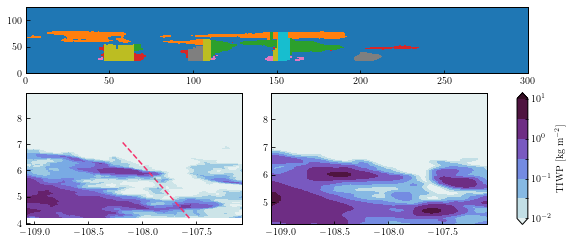

In [16]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm, Normalize

gs = GridSpec(2, 3, width_ratios=[1.0, 1.0, 0.05], height_ratios=[0.5, 1.0])
fig = plt.figure(figsize=(9, 4))
tb_norm = Normalize(200, 280)
tiwp_norm = LogNorm(1e-2, 1e1)

ax = fig.add_subplot(gs[0, :])
cs_data = cldclass_data[{"rays": slice(0, 300)}]
lons_cs = cs_data.longitude.data
lats_cs = cs_data.latitude.data
ax.pcolormesh(cs_data.cloud_class.T[::-1], cmap="tab10")

ax = fig.add_subplot(gs[1, 0])
levels = np.linspace(200, 280, 9)
ax.contourf(cpcir_data.lon, cpcir_data.lat, cpcir_data.Tb.data[0], norm=tb_norm, levels=levels, extend="both", cmap="cmo.dense_r")
plt.plot(lons_cs, lats_cs, ls="--")
dc_flag = cs_data.cloud_class.data.max(-1) == 8
plt.plot(lons_cs[dc_flag], lats_cs[dc_flag], ls="--")

ax = fig.add_subplot(gs[1, 1])
levels = np.logspace(-2, 1, 7)
m = ax.contourf(ccic_data.longitude, ccic_data.latitude, np.maximum(ccic_data.tiwp.data[0], 1e-3), norm=tiwp_norm, levels=levels, extend="both")

cax = fig.add_subplot(gs[1, 2])
plt.colorbar(m, label="TIWP [kg m$^{-2}$]", cax=cax)

##  Tb and IWP distributions

To assess the relation between cloud class and IR brightness temperatures, we plot the distributions for each class.

In [22]:
tb_bins = np.linspace(180, 300, 101)
tb_dists = np.zeros((8, 100))
for cls in np.arange(1, 9):
    tbs = matched.Tb.data[matched.cloud_class.data == cls]
    tb_dists[cls - 1] = np.histogram(tbs, tb_bins)[0]

In [23]:
tiwp_bins = np.logspace(-4, 2, 101)
tiwp_dists = np.zeros((8, 100))
for cls in np.arange(1, 9):
    tiwp = matched.tiwp.data[matched.cloud_class.data == cls]
    tiwp_dists[cls - 1] = np.histogram(tiwp, tiwp_bins)[0]

In [24]:
import seaborn as sns

In [25]:
from matplotlib import cm
convective_classes = [6, 7, 8]
convective_colors = [cm.get_cmap("Reds")(val) for val in [0.3, 0.5, 0.7]]
convective_names = ["Cu", "Ns", "DC"]
stratiform_classes = [1, 2, 3, 4, 5]
stratiform_colors = [cm.get_cmap("Blues")(val) for val in [0.3, 0.4, 0.5, 0.6, 0.7]]
stratiform_names = ["High", "As", "Ac", "St", "Sc"]

/tmp/ipykernel_1305269/3145267281.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  convective_colors = [cm.get_cmap("Reds")(val) for val in [0.3, 0.5, 0.7]]
/tmp/ipykernel_1305269/3145267281.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  stratiform_colors = [cm.get_cmap("Blues")(val) for val in [0.3, 0.4, 0.5, 0.6, 0.7]]


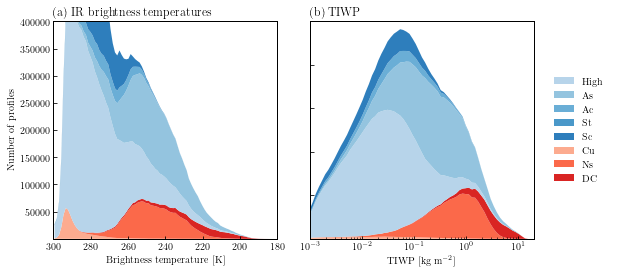

In [85]:
import seaborn as sns
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 4))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.2])

# tbs
ax = fig.add_subplot(gs[0, 0])
tbs = 0.5 * (tb_bins[1:] + tb_bins[:-1])
lower = 0
handles = []
for cc, clr, name in zip(convective_classes, convective_colors, convective_names):
    handles.append(ax.fill_between(tbs, lower, lower + tb_dists[cc - 1], facecolor=clr, label=name))
    lower = lower + tb_dists[cc - 1]
for sc, clr, name in zip(stratiform_classes, stratiform_colors, stratiform_names):
    handles.append(ax.fill_between(tbs, lower, lower + tb_dists[sc - 1], facecolor=clr, label=name))
    lower = lower + tb_dists[sc - 1]

ax.set_xlim(300, 180)
ax.set_xlabel("Brightness temperature [K]")
ax.set_ylabel("Number of profiles")
ax.set_ylim(1, 400_000)
ax.set_title("(a) IR brightness temperatures")
#ax.set_yscale("log")

# tiwp
ax = fig.add_subplot(gs[0, 1])
tiwp = 0.5 * (tiwp_bins[1:] + tiwp_bins[:-1])
handles_s = []
handles_c = []
lower = 0
for cc, clr, name in zip(convective_classes, convective_colors, convective_names):
    handles_c.append(ax.fill_between(tiwp, lower, lower + tiwp_dists[cc - 1], facecolor=clr, label=name))
    lower = lower + tiwp_dists[cc - 1]
for sc, clr, name in zip(stratiform_classes, stratiform_colors, stratiform_names):
    handles_s.append(ax.fill_between(tiwp, lower, lower + tiwp_dists[sc - 1], facecolor=clr, label=name))
    lower = lower + tiwp_dists[sc - 1]
ax.set_xlim(1e-3, 2e1)
ax.set_xscale("log")
ax.set_xlabel("TIWP [kg m$^{-2}$]")
ax.set_ylim(1, 500_000)
ax.set_yticklabels([])
ax.set_title("(b) TIWP")

# Legend
ax = fig.add_subplot(gs[0, 2])
ax.set_axis_off()
ax.legend(handles=handles_s + handles_c, frameon=False, loc="right")

fig.savefig("cloud_class_dists.pdf", bbox_inches="tight")

## Precision-recall curves

In [27]:
valid = (matched.cloud_class.data >= 0) * (matched.Tb.data >= 0) * (matched.tiwp.data >= 0)
convective = matched.cloud_class.data[valid] >= 7
tbs = matched.Tb.data[valid]
tiwp = matched.tiwp.data[valid]

In [28]:
from sklearn.metrics import precision_recall_curve
prec_c_tb, rec_c_tb, thresh_c_tb = precision_recall_curve(convective, -tbs)
prec_c_tiwp, rec_c_tiwp, thresh_c_tiwp = precision_recall_curve(convective, tiwp)

The threshold for tracking convective clouds is determined as the threshold that achieves a recall of 0.8.

In [63]:
thresh_ind = np.argmin(np.abs(thresh_c_tb + 256))
ot_tb_c = thresh_c_tb[thresh_ind]
or_tb_c = rec_c_tb[thresh_ind]
op_tb_c = prec_c_tb[thresh_ind]
thresh_ind = np.argmin(np.abs(thresh_c_tiwp - 0.24))
ot_tiwp_c = thresh_c_tiwp[thresh_ind]
or_tiwp_c = rec_c_tiwp[thresh_ind]
op_tiwp_c = prec_c_tiwp[thresh_ind]

In [64]:
ind_241 = np.argmin(np.abs(thresh_c_tb + 241))

In [30]:
valid = (matched.cloud_class.data >= 0) * (matched.Tb.data >= 0) * (matched.tiwp.data >= 0)
deep_convective = matched.cloud_class.data[valid] >= 8
tbs = matched.Tb.data[valid]
tiwp = matched.tiwp.data[valid]

In [31]:
from sklearn.metrics import precision_recall_curve
prec_dc_tb, rec_dc_tb, thresh_dc_tb = precision_recall_curve(deep_convective, -tbs)
prec_dc_tiwp, rec_dc_tiwp, thresh_dc_tiwp = precision_recall_curve(deep_convective, tiwp)

In [65]:
thresh_ind = np.argmin(np.abs(thresh_dc_tb + 220))
ot_tb_dc = thresh_dc_tb[thresh_ind]
or_tb_dc = rec_dc_tb[thresh_ind]
op_tb_dc = prec_dc_tb[thresh_ind]
thresh_ind = np.argmin(np.abs(thresh_dc_tiwp - 2.6))
ot_tiwp_dc = thresh_dc_tiwp[thresh_ind]
or_tiwp_dc = rec_dc_tiwp[thresh_ind]
op_tiwp_dc = prec_dc_tiwp[thresh_ind]

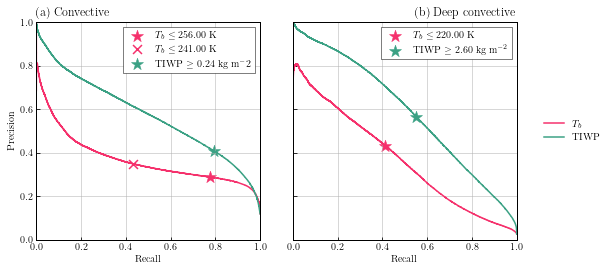

In [84]:
from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.2])
fig = plt.figure(figsize=(10, 4))
              
ax = fig.add_subplot(gs[0, 0])
handles = []
handles_s = []
handles += ax.plot(rec_c_tb, prec_c_tb, label="Brightness temperatures")
handles += ax.plot(rec_c_tiwp, prec_c_tiwp, label="TIWP")
handles_s.append(ax.scatter([or_tb_c], [op_tb_c], c="C0", marker="*", s=160, label=rf"$T_b \leq {-ot_tb_c:.2f}$ K"))
handles_s.append(ax.scatter([rec_c_tb[ind_241]], [prec_c_tb[ind_241]], c="C0", marker="x", s=80, label=rf"$T_b \leq {241:.2f}$ K"))
handles_s.append(ax.scatter([or_tiwp_c], [op_tiwp_c], c="C1", marker="*", s=160, label=rf"TIWP $\geq {ot_tiwp_c:.2f}$ kg m$^{-2}$"))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
ax.set_title("(a) Convective", loc="left")
ax.legend(handles=handles_s)
ax.grid()

ax = fig.add_subplot(gs[0, 1])
handles = []
handles += ax.plot(rec_dc_tb, prec_dc_tb, label="$T_b$")
handles += ax.plot(rec_dc_tiwp, prec_dc_tiwp, label="TIWP")
handles_s = []
handles_s.append(ax.scatter([or_tb_dc], [op_tb_dc], c="C0", marker="*", s=160, label=rf"$T_b \leq {-ot_tb_dc:.2f}$ K"))
handles_s.append(ax.scatter([or_tiwp_dc], [op_tiwp_dc], c="C1", marker="*", s=160, label=rf"TIWP $\geq {ot_tiwp_dc:.2f}$ kg m$^{{-2}}$"))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_yticklabels([])
ax.set_xlabel("Recall")
ax.set_title("(b) Deep convective", loc="right")
ax.legend(handles=handles_s)
ax.grid()

ax = fig.add_subplot(gs[0, 2])
ax.set_axis_off()
ax.legend(handles=handles, loc="center", frameon=False)
fig.savefig("pr_curves.pdf", bbox_inches="tight")